In [550]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [552]:
# Define data directories
img1_data_dir = './tibetan_glyphs'
img2_data_dir = './chinese_glyphs'

In [554]:
# Function to load images from directory
def load_images_from_dir(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            img = tf.keras.preprocessing.image.load_img(
                os.path.join(directory, filename), 
                target_size=(120, 90), 
                color_mode='grayscale'
            )
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = img.astype('float32') / 255.0  # Normalize pixel values
            images.append(img)
    return np.array(images)

In [556]:
# Load images from directories
img1_data = load_images_from_dir(img1_data_dir)
img2_data = load_images_from_dir(img2_data_dir)

In [559]:
# Get subset of data from img2_data
img1_data = img1_data[:1000]
img2_data_subset = img2_data[:1000]  # Change the number to get a different subset

Shape of img1_data: (1000, 120, 90, 1)
Shape of img2_data_subset: (1000, 120, 90, 1)


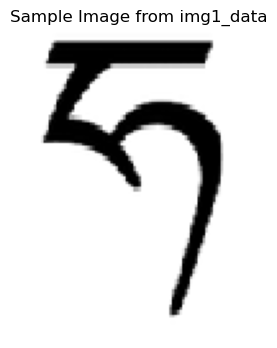

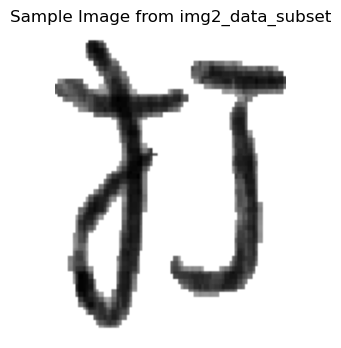

In [561]:
# Print shapes
print("Shape of img1_data:", img1_data.shape)
print("Shape of img2_data_subset:", img2_data_subset.shape)

# Display a sample image from img1_data
plt.figure(figsize=(4, 4))
plt.imshow(img1_data[0].reshape(120, 90), cmap='gray')
plt.axis('off')
plt.title('Sample Image from img1_data')
plt.show()

# Display a sample image from img2_data_subset
plt.figure(figsize=(4, 4))
plt.imshow(img2_data_subset[0].reshape(120, 90), cmap='gray')
plt.axis('off')
plt.title('Sample Image from img2_data_subset')
plt.show()

In [563]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=[120, 90, 1]))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (3, 3), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (3, 3), padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (3, 3), padding='same', activation='tanh'))
    return model


In [565]:
generator = make_generator_model()
generator.summary()

Model: "sequential_279"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_560 (Conv2D)             │ (None, 120, 90, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_794 (LeakyReLU)     │ (None, 120, 90, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_561 (Conv2D)             │ (None, 120, 90, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_795 (LeakyReLU)     │ (None, 120, 90, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_368            │ (None, 120, 90, 128)   │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_796 (LeakyReLU)     │ (None, 120, 90, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_369            │ (None, 120, 90, 64)    │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_797 (LeakyReLU)     │ (None, 120, 90, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_370            │ (None, 120, 90, 1)     │           577 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,449 (1.13 MB)

 Trainable params: 296,449 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [567]:
# Define discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[120, 90, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [569]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_280"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_562 (Conv2D)             │ (None, 60, 45, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_798 (LeakyReLU)     │ (None, 60, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_190 (Dropout)           │ (None, 60, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_563 (Conv2D)             │ (None, 30, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_799 (LeakyReLU)     │ (None, 30, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_191 (Dropout)           │ (None, 30, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_139 (Flatten)           │ (None, 88320)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 1)              │        88,321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,817 (636.00 KB)

 Trainable params: 162,817 (636.00 KB)

 Non-trainable params: 0 (0.00 B)

In [571]:
class CycleGAN(tf.keras.Model):
    def __init__(self, generator_g, generator_f, discriminator_x, discriminator_y):
        super(CycleGAN, self).__init__()
        self.generator_g = generator_g
        self.generator_f = generator_f
        self.discriminator_x = discriminator_x
        self.discriminator_y = discriminator_y

    def compile(self, gen_g_optimizer, gen_f_optimizer, disc_x_optimizer, disc_y_optimizer, cycle_loss_fn):
        super(CycleGAN, self).compile()
        self.gen_g_optimizer = gen_g_optimizer
        self.gen_f_optimizer = gen_f_optimizer
        self.disc_x_optimizer = disc_x_optimizer
        self.disc_y_optimizer = disc_y_optimizer
        self.cycle_loss_fn = cycle_loss_fn

    def train_step(self, batch_data):
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Generate fake images
            fake_y = self.generator_g(real_x, training=True)
            fake_x = self.generator_f(real_y, training=True)

            # Generate reconstructed images
            reconstructed_x = self.generator_f(fake_y, training=True)
            reconstructed_y = self.generator_g(fake_x, training=True)

            # Compute cycle consistency loss
            cycle_loss_x = self.cycle_loss_fn(real_x, reconstructed_x)
            cycle_loss_y = self.cycle_loss_fn(real_y, reconstructed_y)
            total_cycle_loss = cycle_loss_x + cycle_loss_y

            # Compute generator adversarial loss
            gen_g_adv_loss = -tf.reduce_mean(self.discriminator_y(fake_y))
            gen_f_adv_loss = -tf.reduce_mean(self.discriminator_x(fake_x))
            total_gen_adv_loss = gen_g_adv_loss + gen_f_adv_loss

            # Total generator loss
            total_gen_loss = total_gen_adv_loss + total_cycle_loss

            # Compute discriminator adversarial loss
            disc_x_loss_real = tf.reduce_mean(tf.square(self.discriminator_x(real_x) - 1))
            disc_x_loss_fake = tf.reduce_mean(tf.square(self.discriminator_x(fake_x)))
            disc_x_loss = 0.5 * (disc_x_loss_real + disc_x_loss_fake)

            disc_y_loss_real = tf.reduce_mean(tf.square(self.discriminator_y(real_y) - 1))
            disc_y_loss_fake = tf.reduce_mean(tf.square(self.discriminator_y(fake_y)))
            disc_y_loss = 0.5 * (disc_y_loss_real + disc_y_loss_fake)

        # Compute gradients and update weights
        gen_g_gradients = tape.gradient(total_gen_loss, self.generator_g.trainable_variables)
        gen_f_gradients = tape.gradient(total_gen_loss, self.generator_f.trainable_variables)
        disc_x_gradients = tape.gradient(disc_x_loss, self.discriminator_x.trainable_variables)
        disc_y_gradients = tape.gradient(disc_y_loss, self.discriminator_y.trainable_variables)

        self.gen_g_optimizer.apply_gradients(zip(gen_g_gradients, self.generator_g.trainable_variables))
        self.gen_f_optimizer.apply_gradients(zip(gen_f_gradients, self.generator_f.trainable_variables))
        self.disc_x_optimizer.apply_gradients(zip(disc_x_gradients, self.discriminator_x.trainable_variables))
        self.disc_y_optimizer.apply_gradients(zip(disc_y_gradients, self.discriminator_y.trainable_variables))

        return {
            "total_gen_loss": total_gen_loss,
            "total_cycle_loss": total_cycle_loss,
            "total_gen_adv_loss": total_gen_adv_loss,
            "disc_x_loss": disc_x_loss,
            "disc_y_loss": disc_y_loss
        }


In [573]:
# Instantiate generator and discriminator models
generator_g = make_generator_model()
generator_f = make_generator_model()
discriminator_x = make_discriminator_model()
discriminator_y = make_discriminator_model()

# Compile CycleGAN model
cycle_gan_model = CycleGAN(generator_g, generator_f, discriminator_x, discriminator_y)
cycle_gan_model.compile(
    gen_g_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_f_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_x_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_y_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    cycle_loss_fn=tf.keras.losses.Huber()
)


In [577]:
# Train the model
cycle_gan_model.fit(
    img1_data, img2_data_subset,
    epochs=1,
    batch_size=8
)

125/125 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - disc_x_loss: 0.0124 - disc_y_loss: 0.0988 - total_cycle_loss: 0.1355 - total_gen_adv_loss: -0.2094 - total_gen_loss: -0.0740


Shape of img1_data: (1000, 120, 90, 1)
Shape of img2_data_subset: (1000, 120, 90, 1)


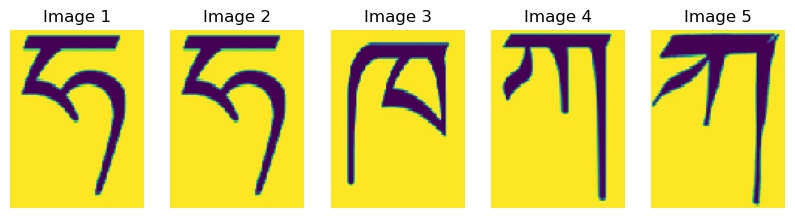

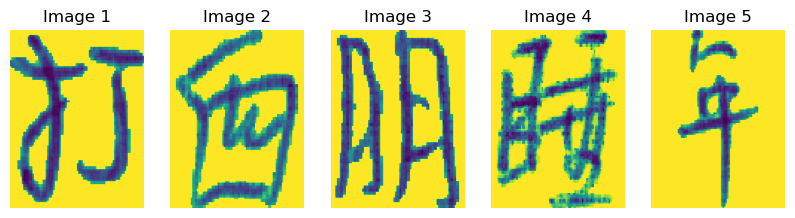

In [589]:
import matplotlib.pyplot as plt

# Check shapes
print("Shape of img1_data:", img1_data.shape)
print("Shape of img2_data_subset:", img2_data_subset.shape)

# Visualize images from img1_data
plt.figure(figsize=(10, 5))
for i in range(5):  # Plot the first 5 images
    plt.subplot(1, 5, i + 1)
    plt.imshow(img1_data[i])  # Assuming img1_data contains images in the correct format
    plt.axis('off')
    plt.title('Image {}'.format(i + 1))
plt.show()

# Visualize images from img2_data_subset
plt.figure(figsize=(10, 5))
for i in range(5):  # Plot the first 5 images
    plt.subplot(1, 5, i + 1)
    plt.imshow(img2_data_subset[i])  # Assuming img2_data_subset contains images in the correct format
    plt.axis('off')
    plt.title('Image {}'.format(i + 1))
plt.show()


In [601]:
# Generate images using the trained generator
generated_images = generator_g.predict(img1_data)

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 546ms/step


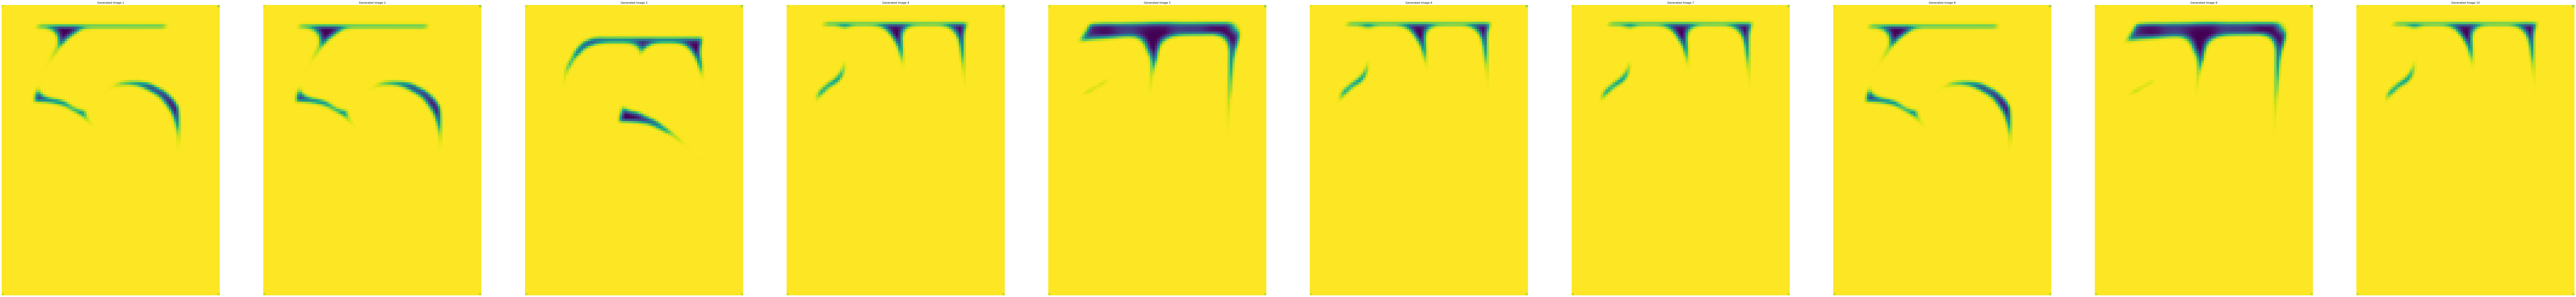

In [619]:
# Visualize the generated images
import matplotlib.pyplot as plt
plt.figure(figsize=(200,100))
for i in range(10):  # Visualize the first 5 generated images
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated_images[i])  # Assuming generated_images is in the correct format
    plt.axis('off')
    plt.title('Generated Image {}'.format(i + 1))
plt.show()